# Text classification with EU CORDIS Dataset

This Notebook presents an NLP classification problem with three different classifiers:
- Regex
- FastText
- Latent Semantic Indexing (with a K-Nearest Neighbor classifier)

This Notebook consists of data gathering and preprocessing operations, followed by building all three models. The last part is about evaulation of the models

## Discover, access, distill

First we import all the required libraries

In [2]:
import pandas as pd
import numpy as np
import re
import fasttext as ft
import gensim
from sklearn.model_selection import train_test_split
import logging
from gensim import models
from gensim import corpora
from collections import defaultdict
from sklearn.neighbors import KNeighborsClassifier
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
import sklearn.metrics as metrics
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

This example is made by using open EU research project data. The class we want to predict is ICT/IT-related projects. Labeling the data is made by manually choosing categories by using CORDIS Horizon2020 keyword list and picking all ICT-related topics by their keywords. Not the most scientific method, but good enough approximation with limited resources. We give all the positive classes label code 1 and all the negative classes a label code 0. Data is the concatenated into a single dataframe

In [8]:
cordis_reports = pd.read_excel("cordis_reports.xlsx")
categs = pd.read_excel("pos_label_categories.xlsx") #ICT-related categories
categs.head()

,code,topicKeywordTitle,Column1
0,IoT-03-2017,Advanced computing,x
1,IoT-02-2016,Advanced computing,x
2,IoT-01-2016,Advanced computing,x
3,ICT-30-2015,Advanced computing,x
4,ICT-11-2017,Advanced computing,x


In [38]:
cordis_reports.head()

,rcn,language,title,teaser,summary,workPerformed,finalResults,lastUpdateDate,country,projectID,projectAcronym,programme,topics,relatedFile,url
0,453405,en,Periodic Reporting for period 1 - DiAMS (SEMI-...,More than 420 M people live with diabetes glob...,More than 420 M people live with diabetes glob...,The development of the feasibility study gave ...,DiAMS will disrupt insulin therapy. It is invi...,2020-04-25 14:20:41,NaN,867975,DiAMS,H2020-EU.3.;H2020-EU.2.3.;H2020-EU.2.1.,EIC-SMEInst-2018-2020,/docs/results/h2020/867/867975_PS/image.jpg,https://amf.ch/
1,453406,en,Periodic Reporting for period 1 - ArtIST (Pre-...,An estimated 4.1 million people are affected b...,An estimated 4.1 million people are affected b...,The EU grant has helped us pushing forward our...,"During the development of the project, and tog...",2020-04-25 14:21:02,NaN,868365,ArtIST,H2020-EU.3.;H2020-EU.2.3.;H2020-EU.2.1.,EIC-SMEInst-2018-2020,/docs/results/h2020/868/868365_PS/figure1-clov...,http://www.clovermsdataanalysis.com
2,449137,en,Periodic Reporting for period 1 - BioSolar Lea...,Due to fast worldwide population growth (from ...,Due to fast worldwide population growth (from ...,Arborea completed a full analysis of the techn...,The expected outcome is to optimize manufactur...,2020-04-25 15:29:00,NaN,878259,BioSolar Leaf,H2020-EU.3.;H2020-EU.2.3.;H2020-EU.2.1.,EIC-SMEInst-2018-2020,/docs/results/h2020/878/878259_PS/biosolar-lea...,http://arborea.io/
3,220274,en,Periodic Reporting for period 2 - NanOQTech (N...,Quantum technologies are developed to overcome...,Quantum technologies are developed to overcome...,The first part of the work carried out during ...,The nanoparticles developed during NanOQTech h...,2020-04-25 07:28:40,NaN,712721,NanOQTech,H2020-EU.1.2.1.,FETOPEN-RIA-2014-2015,/docs/results/h2020/712/712721_PS/imagekit.png,http://www.nanoqtech.eu
4,449138,en,Periodic Reporting for period 1 - Sampols (A n...,"OrbiWise is a Swiss company based in Geneva, f...","OrbiWise is a Swiss company based in Geneva, f...","In this Feasibility Study, we have analyzed th...",There are two groups of competitors in the noi...,2020-04-25 15:01:40,NaN,878246,Sampols,H2020-EU.3.;H2020-EU.2.3.;H2020-EU.2.1.,EIC-SMEInst-2018-2020,/docs/results/h2020/878/878246_PS/image-1.png,http://www.orbiwise.com


In [3]:
search_values = categs['code'].tolist()
pos = cordis_reports.loc[cordis_reports['topics'].str.contains('|'.join(search_values), case=False)]
pos['label_code'] = 1
pos.shape

/mnt/c/Users/teemu.mikkonen/Documents/Dippa/env2/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


(1368, 16)

We remove all topics that do not clearly provide a theme or a category. For instance, SMEinst is directed to small and middle-sized companies and the actual topic can be just about anything. We judge that these wil bring too much noise into the dataset and they are removed

In [4]:
neg = cordis_reports.loc[~cordis_reports['topics'].str.contains('|'.join(search_values), case=False)]
no_topics = ['MSCA', 'SMEinst', 'ERC']
neg = neg.loc[~neg['topics'].str.contains('|'.join(no_topics), case = False)]
neg['label_code'] = 0

In [5]:
data = pd.concat([pos,neg])
data.shape

(6487, 16)

We drop all the unnecessary columns from the data. For the initial verion of this *WE ONLY USE SUMMARY DATA* as our features. This dataset also contains "workPerformed" and "finalResults" columns that may add to the information in the features. 

In [6]:
data.drop(['rcn', 'language', 'title','teaser',
           'lastUpdateDate', 'country', 'projectID',
           'projectAcronym', 'programme', 'relatedFile',
          'url', 'topics'], axis = 1, inplace= True)

In [7]:
data.drop(['workPerformed', 'finalResults'], axis = 1, inplace =True)
data.reset_index(drop=True, inplace =True)

##### Text preprocessing

We remove all Stopwords, unnecessary symbols and transform the text into lowercase letters

In [8]:
#import nltk
#nltk.download('stopwords') #uncomment the first time you run the code
from nltk.corpus import stopwords

In [9]:
sw = stopwords.words('english')

def preprocess_word(word, stopwords):

    word = re.sub("[^A-Za-z0-9ÄäÖö-]+", "", word)
    word = re.sub("-", " ", word)
    word = word.strip().lower()
    if type(word) != None:
        if word not in stopwords:
            return word
        else:
            return ""

def preprocess_sent(sent, stopwords):

    if sent != "":
        words = sent.strip().split(" ")
        final_sent = " ".join([preprocess_word(word, stopwords) for word in words if type(word) != None])
        return final_sent.strip()

def preprocess_row(teksti, stopwords):

    if type(teksti) == str:
        sents = teksti.strip().split(".")
        sents = filter(None,sents)
        teksti = ".".join([preprocess_sent(sent, stopwords) for sent in sents if type(sent) != None])
        return teksti

In [10]:
data['preprocessed'] = [preprocess_row(i, sw) for i in data['summary']]

After preprocessing, we can begin building the classifier models

### Regex model

Regex model is based on simply finding the string 'ICT' from report. If found, class is declared 1, if not, 0. 

In [11]:
def check_regex(string, txt):
    if type(txt) == str:
        if re.search(string, txt):
            return True
        else: 
            return False
    else:
        return False

In [12]:
classifier_string = re.compile(r'ict', re.I)
data['pred_label'] = [1 if check_regex(classifier_string, i) is True else 0 for i in data['summary']]
data.head()

,summary,label_code,preprocessed,pred_label
0,The WAKeMeUP project objective is to set up a ...,1,wakemeup project objective set pilot line ...,0
1,The BroadWay project will take the first procu...,1,broadway project take first procurement step...,0
2,"""LiDAR cyber security interference problem sta...",1,lidar cyber security interference problem stat...,0
3,Blockchain and distributed ledger technologies...,1,blockchain distributed ledger technologies dl...,1
4,"The security problems arising, in Internet of ...",1,security problems arising internet things io...,0


### fastText-model

FastText model is based on word representations and subword information. The data is written into files with label written before text. We also perform train-test-split and use consequent split in both fastText and LSI-classification to ensure comparability

In [14]:
df_ft = data
label = []
for i in df_ft['label_code']:
    if i == 1:
        label.append("__label__ict")
    else:
        label.append("__label__notict")
df_ft['str_label'] = label

In [15]:
split_size = 0.20
train, test = train_test_split(df_ft, test_size = split_size, random_state=12)
df_train = pd.DataFrame(data = {'label':train['str_label'], 'text':train['preprocessed']})
df_test = pd.DataFrame(data = {'label':test['str_label'], 'text':test['preprocessed']})

In [16]:
df_train.to_csv("train.txt", sep='\t', index = False, header = False)
df_test.to_csv("test.txt", sep='\t', index = False, header = False)

In the following cell, we initialize and run the classifier. Classifier reads the data from files in the working directory

In [17]:
ft_classifier = ft.train_supervised(
    'train.txt',
    label_prefix = '__label__',
    epoch = 100,
    dim = 100,
    word_ngrams = 3,
    ws = 3)

In [18]:
df_test['text'] = df_test['text'].str.replace("__label__", "")
ft_score = ft_classifier.predict(df_test['text'].tolist(), k=2)
score_label = [i for i in ft_score[0]]
score_prob = [i for i in ft_score[1]]

ft_prob = pd.DataFrame(data = {'text': df_test['text'], 'label':df_test['label'], 'score':score_label})
ft_prob['score'] = [i[0] for i in ft_prob['score']]
ft_prob['label_code'] = [1 if i == '__label__ict' else 0 for i in ft_prob['label']]
ft_prob['pred_label'] = [1 if i == '__label__ict' else 0 for i in ft_prob['score']]

We write classification probability into single column to use in the ROC-curve. 

In [19]:
ftlabel = []
ftprob = []
for i in range(len(ft_score[0])):
    ftlabel.append(score_label[i][0])
    if score_label[i][0] == '__label__ict':
        ftprob.append(score_prob[i][0])
    else:
        ftprob.append(score_prob[i][1])
ft_prob['score_prob'] = ftprob
ft_prob.head()

,text,label,score,label_code,pred_label,score_prob
5185,work investigates results investigating pos...,__label__notict,__label__notict,0,0,0.121579
5044,central objective rysq project implement ...,__label__notict,__label__notict,0,0,0.042355
4764,lithuanian based transport telecommunications ...,__label__notict,__label__notict,0,0,0.020436
1562,overall concept kaminler project set deve...,__label__notict,__label__notict,0,0,0.000011
403,information communication technology ict ess...,__label__ict,__label__notict,1,0,0.430076


### LSI-model

LSI model is based on giving documents a semantic vector representation. First, we extraxt features by bag-of-words word-frequency, after which we give each word a TF-IDF-score. Then we reduce the dimensionality of these document vectors in order to create comparable semantic document vectors

In [20]:
texts = data['summary'].tolist()
frequency = defaultdict(int)
for text in texts:
    if text != None:
        tokens = text.split(" ")
        for token in tokens:
            frequency[token] += 1

texts = [
    [token for token in text.split(" ") if frequency[token] > 1 if text != None] #Removing words with frequency of 1 occurrence.
    for text in texts if text != None
]

In [21]:
dictionary = corpora.Dictionary(texts)  #Dictionary for all the words in all the documents

2020-05-25 10:10:27,387 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-05-25 10:10:29,189 : INFO : built Dictionary(48006 unique tokens: ['(PCM)', '-', '28nm', 'Additional', 'Change']...) from 6487 documents (total 1877666 corpus positions)


Latent semantic indexing uses an unsupervised topic model, which represents each document as a sum of the topic values

In [22]:
class MyCorpus(object):
    def __iter__(self):
        for text in texts:
            yield dictionary.doc2bow(text)

corpus = MyCorpus()
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]
lsi_model = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=200, power_iters=10)

2020-05-25 10:10:29,196 : INFO : collecting document frequencies
2020-05-25 10:10:29,198 : INFO : PROGRESS: processing document #0
2020-05-25 10:10:30,928 : INFO : calculating IDF weights for 6487 documents and 48006 features (1103816 matrix non-zeros)
2020-05-25 10:10:31,244 : INFO : using serial LSI version on this node
2020-05-25 10:10:31,246 : INFO : updating model with new documents
2020-05-25 10:10:46,520 : INFO : preparing a new chunk of documents
2020-05-25 10:10:47,094 : INFO : using 100 extra samples and 10 power iterations
2020-05-25 10:10:47,096 : INFO : 1st phase: constructing (48006, 300) action matrix
2020-05-25 10:10:48,177 : INFO : orthonormalizing (48006, 300) action matrix
2020-05-25 10:11:48,490 : INFO : 2nd phase: running dense svd on (300, 6487) matrix
2020-05-25 10:11:49,455 : INFO : computing the final decomposition
2020-05-25 10:11:49,457 : INFO : keeping 200 factors (discarding 19.591% of energy spectrum)
2020-05-25 10:11:50,577 : INFO : processed documents up

We give the vector representation to train and test samples of the research data

In [23]:
df_train['doc2bow'] = [dictionary.doc2bow(i.split()) for i in df_train['text'].tolist()]
df_train['tf_idf'] = tfidf[df_train['doc2bow']]
lstr = []
for i in df_train['tf_idf']:
    lstr.append(lsi_model[i])
df_train['lsi'] = lstr
df_train['label_code'] = [1 if i == '__label__ict' else 0 for i in df_train['label']]

In [24]:
df_test['doc2bow'] = [dictionary.doc2bow(i.split()) for i in df_test['text'].tolist()]
df_test['tf_idf'] = tfidf[df_test['doc2bow']]
ls = []
for i in df_test['tf_idf']:
    ls.append(lsi_model[i])
df_test['lsi'] = ls
df_test['label_code'] = [1 if i == '__label__ict' else 0 for i in df_test['label']]
#df_test.head()

Next we form the topic vectors into 200-dimensional vectors and initialize the KNN-classifier

In [25]:
def create_vec(df):
    x =[]
    num = 0
    for i in df['lsi']:
        test = []
        for a in i:
            test.append(a[1])
        
        if test != []:
            x.append(test)
        else:
            print(num)
        num +=1
    return np.array(x)

X = create_vec(df_train)
Y = df_train['label_code']
xt = create_vec(df_test)
yt = df_test['label_code']
neigh = KNeighborsClassifier(n_neighbors=5) 

In order to combat the class imbalance in the data, we oversample the positive class to a ratio of 1:2

In [26]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(0.5)
x_train_res, y_train_res = sm.fit_sample(X,Y)

Using TensorFlow backend.


We fit the oversampled training data to KNN classifier

In [27]:
neigh.fit(x_train_res,y_train_res)
#neigh.fit(X,Y)
preds = neigh.predict_proba(xt) #classification probabilities
pred = preds[:,1]
lsi_labels = neigh.predict(xt)
df_test['pred_label'] = lsi_labels

## Model evaluation

We start the evaluation process by assignin a truth value of the confusion matrix to each sample by comparing the actual class to predicted one. Values are summed and evaluation metrics are calculated based on them. As evaluation metrics we use:
- Precision
- Recall
- F1-score
- AUC (Area under ROC-curve
- PR (Area under Precision-recall-curve

In [29]:
def truth_val(df):
    orig = df['label_code']
    pred = df['pred_label']
    if orig == 1 and pred == 1:
        return 'true_positive'
    if orig == 1 and pred ==0: 
        return 'false_negative'
    if orig == 0 and pred ==1:
        return 'false_positive'
    if orig == 0 and pred == 0:
        return 'true_negative'

df_test['truthvalue'] = df_test.apply(truth_val, axis = 1)
ft_prob['truthvalue'] = ft_prob.apply(truth_val, axis = 1)
data['truthvalue'] = data.apply(truth_val, axis=1)

In [30]:
def sum_truthvals(model):
    
    tp = model['truthvalue'].value_counts()['true_positive']
    fp = model['truthvalue'].value_counts()['false_positive']
    fn = model['truthvalue'].value_counts()['false_negative']
    tn = model['truthvalue'].value_counts()['true_negative']
    
    return [tp, fp, fn, tn]


def calculate_precision(df):

    p = df['True Positives'] / (df['True Positives'] + df['False Positives'])
    return p

def calculate_recall(df):

    r = df['True Positives'] / (df['True Positives'] + df['False Negatives'])
    return r

def calculate_fscore(df):

    f = 2 * df['Precision'] * df['Recall'] / (df['Precision'] + df['Recall'])
    return f


models = {'regex': sum_truthvals(data), 'fastText':sum_truthvals(ft_prob), 'LSI':sum_truthvals(df_test)}

In [31]:
df_eval = pd.DataFrame(data = models, index = ['True Positives', 'False Positives', 'False Negatives', 'True Negatives']).transpose()

In [39]:
df_eval

,True Positives,False Positives,False Negatives,True Negatives,Precision,Recall,F1-score,AUC,PR
regex,379,999,989,4120,0.275036,0.277047,0.276038,0.540946,0.352271
fastText,91,39,158,1010,0.700000,0.365462,0.480211,0.831712,0.576054
LSI,176,291,73,758,0.376874,0.706827,0.491620,0.773529,0.517821


In [33]:
df_eval['Precision'] = calculate_precision(df_eval)
df_eval['Recall'] = calculate_recall(df_eval)
df_eval['F1-score'] = calculate_fscore(df_eval)

In order to gain more comprehensive look at the model performance, we plot ROC and PR-curves that highlight model performance with different thresholds of the classification probability. Threshold is a probability boundary that decides the value, which divides positive class and negative class

In [34]:
def roc_metrics(test_label, pred):
    fpr, tpr, threshold = metrics.roc_curve(test_label, pred)
    roc_auc = metrics.auc(fpr, tpr)
    return fpr, tpr, roc_auc

fpr_lsi, tpr_lsi, roc_auc_lsi = roc_metrics(yt,pred)
fpr_ft, tpr_ft, roc_auc_ft = roc_metrics(yt, ft_prob['score_prob'])
fpr_re, tpr_re, roc_auc_re = roc_metrics(data['label_code'], data['pred_label'])
df_eval['AUC'] = [roc_auc_re, roc_auc_ft, roc_auc_lsi]

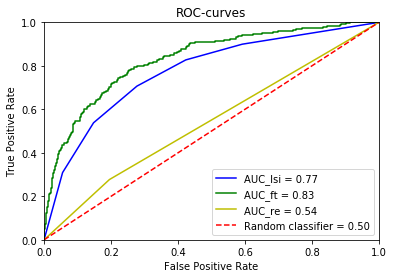

In [35]:
plt.title('ROC-curves')
plt.plot(fpr_lsi, tpr_lsi, 'b', label = 'AUC_lsi = %0.2f' % roc_auc_lsi)
plt.plot(fpr_ft, tpr_ft, 'g', label = 'AUC_ft = %0.2f' % roc_auc_ft)
plt.plot(fpr_re, tpr_re, 'y', label = 'AUC_re = %0.2f' % roc_auc_re)
plt.plot([0, 1], [0, 1],'r--', label = 'Random classifier = 0.50')
plt.legend(loc = 'lower right')

plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [36]:
def pr_metrics(test_label,pred):
    precision, recall, thresholds = precision_recall_curve(test_label,pred)
    area = metrics.auc(recall, precision)
    return precision, recall, area

p_re, r_re, area_re = pr_metrics(data['label_code'], data['pred_label'])
p_ft, r_ft, area_ft = pr_metrics(yt, ft_prob['score_prob'])
p_lsi, r_lsi, area_lsi = pr_metrics(yt,pred)
df_eval['PR'] = [area_re, area_ft,area_lsi]

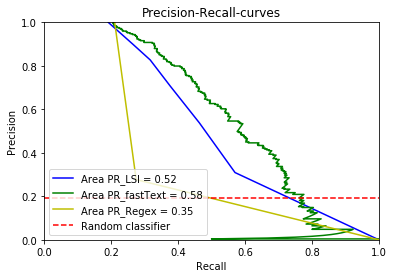

In [37]:
plt.clf()
plt.plot(p_lsi, r_lsi, 'b', label='Area PR_LSI = %0.2f' % area_lsi)
plt.plot(p_ft, r_ft, 'g', label='Area PR_fastText = %0.2f' % area_ft)
plt.plot(p_re, r_re, 'y', label='Area PR_Regex = %0.2f' % area_re)
no_skill = len(yt[yt==1]) / len(yt)
plt.plot([0, 1], [no_skill, no_skill], color='r', linestyle='--', label='Random classifier')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall-curves')
plt.legend(loc="lower left")
plt.show()

In [40]:
df_eval

,True Positives,False Positives,False Negatives,True Negatives,Precision,Recall,F1-score,AUC,PR
regex,379,999,989,4120,0.275036,0.277047,0.276038,0.540946,0.352271
fastText,91,39,158,1010,0.700000,0.365462,0.480211,0.831712,0.576054
LSI,176,291,73,758,0.376874,0.706827,0.491620,0.773529,0.517821


## Results

As we can see, the preliminary results show that fastText classifier has the best success in classifying the samples by all metrics besides Recall. This leads to the conclusion that on situations where it is important to distinquish all the relevant samples from positively classified samples, fastText model performs the best. This applies to situations, where the cost of false negatives is low. 

LSI-model might be more suitable to problems, where finding all positive samples is critical, even with the risk of high number of false positives.

Regex is a naive model, and as such it does not lead to good scores. However, with more structured documents and more refined search keys it could have better scores. It remains however, a static model. 

We will later on add more models as a comparison.